# Project 1 - Franke function

Franke function:

$$f(x,y)=\dfrac{3}{4}\cdot \exp\left[ - \dfrac{(9x-2)^2}{4} - \dfrac{(9y-2)^2}{4} \right] + \dfrac{3}{4}\cdot \exp\left[ - \dfrac{(9x+1)^2}{49} - \dfrac{(9y+1)^2}{10} \right] + \dfrac{1}{2}\cdot \exp\left[ - \dfrac{(9x-7)^2}{4} - \dfrac{(9y-3)^2}{4} \right] - \dfrac{1}{5}\cdot \exp\left[ - (9x-4)^2 -(9y-7)^2\right]$$

defined for: $x,y \in [0,1]$.

1. Regression models:
    1. Ordinary Least Squares
    2. Ridge


2. Resampling techniques:
    1. Bootstrap method
    2. Cross validation


3. Study of Bias-Variance trade off

# Python code for drawing Franke function

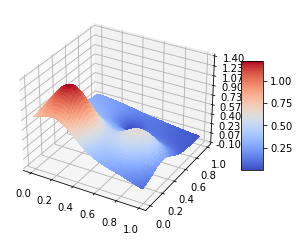

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import math
import random

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Part a) OLS on the Franke functions

#### 1. Perform a standard least square regression analysis using polynomials in x and y up to fifth order. 

#### 2. Find the confidence intervals of the parameters (beta) by computing their variances, evaluate the Mean Squared error (MSE) and the R2 score function.

#### 3. Consider a scaling of the data (for example by subtracting the mean value) and a split of the data in training and test data.

###  

# Solution:

First, we create some functions from scratch that we will use:
   1. Franke function
   2. Franke function with noise.
   3. Design matrix for 5th order polynomial in two variables.
   4. Estimators, confidence intervals, MSE and R2 functions.

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
def FrankeFunctionNoise(x,y,sigma):
    np.random.seed(31415)
    return FrankeFunction(x,y) + 0.1*np.random.randn(len(x))*sigma**2

As we have to do a fitting to a 5th order polynomial in two variables, we have to know how the design matrix will be. This is seen from the polynomial itself:

$$p(x,y) = a_{00} \cdot x^0 \cdot y^0 + a_{01} \cdot x^0 \cdot y^1 + a_{02} \cdot x^0 \cdot y^2 + a_{03} \cdot x^0 \cdot y^3 + a_{04} \cdot x^0 \cdot y^4 + a_{05} \cdot x^0 \cdot y^5 + a_{10} \cdot x^1 \cdot y^0 + a_{11} \cdot x^1 \cdot y^1 + a_{12} \cdot x^1 \cdot y^2 + a_{13} \cdot x^1 \cdot y^3 + a_{14} \cdot x^1 \cdot y^4 + a_{20} \cdot x^2 \cdot y^0 + a_{21} \cdot x^2 \cdot y^1 + a_{22} \cdot x^2 \cdot y^2 + a_{23} \cdot x^2 \cdot y^3 + a_{30} \cdot x^3 \cdot y^0 + a_{31} \cdot x^3 \cdot y^1 + a_{32} \cdot x^3 \cdot y^2 + a_{40} \cdot x^4 \cdot y^0 + a_{41} \cdot x^4 \cdot y^1 + a_{50} \cdot x^5 \cdot y^0$$

It can be also written as

$$p(x,y) = a_{00} + a_{01} \cdot y + a_{02} \cdot y^2 + a_{03} \cdot y^3 + a_{04} \cdot y^4 + a_{05} \cdot y^5 + a_{10} \cdot x + a_{11} \cdot x \cdot y + a_{12} \cdot x \cdot y^2 + a_{13} \cdot x \cdot y^3 + a_{14} \cdot x \cdot y^4 + a_{20} \cdot x^2  + a_{21} \cdot x^2 \cdot y + a_{22} \cdot x^2 \cdot y^2 + a_{23} \cdot x^2 \cdot y^3 + a_{30} \cdot x^3 + a_{31} \cdot x^3 \cdot y + a_{32} \cdot x^3 \cdot y^2 + a_{40} \cdot x^4 + a_{41} \cdot x^4 \cdot y + a_{50} \cdot x^5$$



Therefore, the design matrix X has a dimension of $n\times21$.

$$X = \left[ \begin{array}{ccccc}
    x_{0}^0\cdot y_{0}^0 & x_{0}^0\cdot y_{0}^1 & \dots & x_{0}^4\cdot y_{0}^1 & x_{0}^5\cdot y_{0}^0     \\
    \\
    x_{1}^0\cdot y_{1}^0 & x_{1}^0\cdot y_{1}^1 & \dots & x_{1}^4\cdot y_{1}^1 & x_{1}^5\cdot y_{1}^0     \\
    \\
    \vdots & \vdots & \ddots & \vdots & \vdots\\
    \\
    x_{n-2}^0\cdot y_{n-2}^0 & x_{n-2}^0\cdot y_{n-2}^1 & \dots & x_{n-2}^4\cdot y_{n-2}^1 & x_{n-2}^5\cdot y_{n-2}^0\\
    \\
    x_{n-1}^0\cdot y_{n-1}^0 & x_{n-1}^0\cdot y_{n-1}^1 & \dots & x_{n-1}^4\cdot y_{n-1}^1 & x_{n-1}^5\cdot y_{n-1}^0
\end{array}\right]$$

The design matrix and the estimators are calculated with the following functions:

In [4]:
def DesignMatrix(x,y,n):
    p=n+1 #n is the degree of the polynomial and p includes the 0th order term
    no_terms_pol = math.comb(2+n, n)
    X_matrix = np.ones((len(x),no_terms_pol))
    k=0
    for i in range(0,p):
        for j in range(0,p):
            if i+j<p:
                X_matrix[:,k]=(x**i)*(y**j)
                k+=1
    return X_matrix

In [5]:
def estimators(X, Z):
    return np.linalg.inv(X.T @ X) @ X.T @ Z

In [6]:
def conf_int_beta(X, Z, sigma):
    X_T_X = np.linalg.inv(X.T @ X)
    var_beta_mat = sigma**2 * np.ones(np.shape(X_T_X)[0])
    for i in range(np.shape(X_T_X)[0]):
        var_beta_mat[i] *= X_T_X[i,i]
    return var_beta_mat

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

# 

### Part a.1) OLS with 5th order degree polynomial

#### Definition for the x, y values and the Franke function values

In [7]:
#Values for x,y
x = np.round(np.arange(0,1,0.05),3)

xy_val = np.zeros((len(x)**2,2))      #2D array where 0-row values are x-values and 1-row are y-values
z_val = np.zeros(len(x)**2)           #1D array with z-values associated to Franke function

#Values for xy-array
L,R=0,0
for i in range(len(x)**2):    
    xy_val[i,1]=x[L]
    xy_val[i,0]=x[R]
    R+=1
    if int(R) == 20:
        L+=1
        R=0
        
#z-values from Franke function
z_val = FrankeFunction(xy_val[:,0],xy_val[:,1])
z_val_noise = FrankeFunctionNoise(xy_val[:,0],xy_val[:,1],1)

#### Design matrix

In [8]:
x = xy_val[:,0]
y = xy_val[:,1]

X = DesignMatrix(x,y,5)

print("Design matrix (all data, no scaling, no resampling):")
print(X,"\n")

Design matrix (all data, no scaling, no resampling):
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.25000000e-06
  0.00000000e+00 3.12500000e-07]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e-04
  0.00000000e+00 1.00000000e-05]
 ...
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 5.22006250e-01
  4.95905937e-01 4.43705312e-01]
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 6.56100000e-01
  6.23295000e-01 5.90490000e-01]
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 8.14506250e-01
  7.73780937e-01 7.73780937e-01]] 



#### Estimators from OLS (without noise)

In [9]:
beta_all = estimators(X,z_val)

print("Values for the estimators (all data, no scaling, no resampling):")
print(beta_all)

Values for the estimators (all data, no scaling, no resampling):
[  0.54816337   2.99559795  -5.96536511 -14.08913346  36.40198928
 -19.78809638   5.74654984 -11.2601328   18.50345617 -31.71166945
  18.508273   -24.03100582  33.66372883  -1.189173    -5.92131254
  25.93438392 -42.65810161   6.62934981  -0.90760654  15.88544529
  -7.37090175]


#### Estimators from OLS (with noise)

In [10]:
beta_all_noise = estimators(X,z_val_noise)

print("Values for the estimators (noise, all data, no scaling, no resampling):")
print(beta_all_noise)

Values for the estimators (noise, all data, no scaling, no resampling):
[  0.63162335   2.21696218  -3.36584261 -15.76382267  33.7403252
 -17.30338334   5.93220019 -10.58612482  11.85888927 -20.14495237
  12.55469757 -27.76375133  39.33477438  -4.07110068  -5.86218751
  37.29458655 -50.66649262   9.12226073 -14.77583476  18.93695997
  -1.31076659]


### Part a.2) MSE and R2 values

In [11]:
z_model = X @ beta_all
z_model_noise = X @ beta_all_noise

In [12]:
print("MSE (all data, no scaling, no resampling): ", MSE(z_val,z_model))
print("MSE (noise, all data, no scaling, no resampling): ", MSE(z_val_noise,z_model_noise))
print("\n")
print("R2 (all data, no scaling, no resampling): ", R2(z_val,z_model))
print("R2 (noise, all data, no scaling, no resampling): ", R2(z_val_noise,z_model_noise))

MSE (all data, no scaling, no resampling):  0.0022056645065126413
MSE (noise, all data, no scaling, no resampling):  0.011663260628708863


R2 (all data, no scaling, no resampling):  0.9730266970394285
R2 (noise, all data, no scaling, no resampling):  0.8770149082978442


### Part a.3) Confidence interval

The confidence interval for beta parameters is obtained from the variance of beta parameters:
$$var(\beta) = \sigma^2 \cdot (X^T X)^{-1}$$
Therefore, the confidence interval is defined as:
$$var(\beta_j) = \sigma^2 \cdot (X^T X)^{-1}_{jj}$$

Since we have:
$$y=y_{model}+\mathcal{N}(0,\sigma^2)$$
It only have sense to define the confidence interval for the estimators when the noise term is included n the Franke function.

In [13]:
print("Confidence interval for the estimators (all data, no scaling, no resampling):")
print(conf_int_beta(X,z_val_noise,1))

Confidence interval for the estimators (all data, no scaling, no resampling):
[3.52492381e-01 5.70966698e+01 1.62760008e+03 9.55612179e+03
 1.17803421e+04 2.01014044e+03 5.70966697e+01 9.38916187e+02
 4.91393094e+03 6.44689631e+03 1.43123465e+03 1.62760007e+03
 4.91393094e+03 5.45111872e+03 1.32177515e+03 9.55612179e+03
 6.44689631e+03 1.32177515e+03 1.17803421e+04 1.43123465e+03
 2.01014044e+03]


### Part a.4) Scaling and splitting of the data (with noise data)

#### First, we consider a scale of the data by substracting the mean value to the x, y arrays

In [14]:
#Values for x,y
x = np.round(np.arange(0,1,0.05),3)

#We scale the data by substracting the mean value (0.475). Therefore, the data is centered in [-0.475, 0.475]
x_scaled = x - np.mean(x)

xy_val_scaled = np.zeros((len(x_scaled)**2,2))      #2D array where 0-row values are x-values and 1-row are y-values
z_val_scaled = np.zeros(len(x_scaled)**2)           #1D array with z-values associated to Franke function

#Values for xy-array
L,R=0,0
for i in range(len(x_scaled)**2):    
    xy_val_scaled[i,1]=x_scaled[L]
    xy_val_scaled[i,0]=x_scaled[R]
    R+=1
    if int(R) == 20:
        L+=1
        R=0
        
#z-values from Franke function
z_val_scaled = FrankeFunctionNoise(xy_val[:,0],xy_val[:,1],1)

#### Second, we split the data from scratch

In [15]:
#Algorithm for splitting the data between test (10%) and train (80%)
random.seed(31415)
#1st. Generate the position for the values we pop from the array to create the test values
test_frac=1/5
train_pos=list(range(len(z_val)))
test_pos=random.sample(train_pos, int(len(train_pos)*test_frac) )

for i in test_pos:
    train_pos.remove(i)
        
#Sort of the values for the indexes
test_pos=np.sort(np.array(test_pos))
train_pos=np.sort(np.array(train_pos))

#2nd. Split between the train:
xy_train, xy_test = [], []
xy_train_scaled, xy_test_scaled = [], []

for i in test_pos:
    xy_test.append(xy_val[i,:])
    xy_test_scaled.append(xy_val_scaled[i,:])
    
#and test data:
for i in train_pos:
    xy_train.append(xy_val[i,:])
    xy_train_scaled.append(xy_val_scaled[i,:])
    
xy_test, xy_train = np.array(xy_test), np.array(xy_train)
xy_test_scaled, xy_train_scaled = np.array(xy_test_scaled), np.array(xy_train_scaled)

#3rd. Get the values for the Franke function
z_test = FrankeFunctionNoise(xy_test[:,0], xy_test[:,1],1) 
z_train = FrankeFunctionNoise(xy_train[:,0],xy_train[:,1],1)

z_test_scaled = FrankeFunctionNoise(xy_test_scaled[:,0],xy_test_scaled[:,1],1)
z_train_scaled = FrankeFunctionNoise(xy_train_scaled[:,0], xy_train_scaled[:,1],1)

#### Design matrices

In [16]:
x_test, y_test = xy_test[:,0], xy_test[:,1]
X_test = DesignMatrix(x_test,y_test,5)
print("Design matrix (test data, no scaling, no resampling):")
print(X_test,"\n")

x_train, y_train = xy_train[:,0], xy_train[:,1]
X_train = DesignMatrix(x_train,y_train,5)
print("Design matrix (train data, no scaling, no resampling):")
print(X_train,"\n")

x_test_scaled, y_test_scaled = xy_test_scaled[:,0], xy_test_scaled[:,1]
X_test_scaled = DesignMatrix(x_test_scaled,y_test_scaled,5)
print("Design matrix (test data, scaled, no resampling):")
print(X_test_scaled,"\n")

x_train_scaled, y_train_scaled = xy_train_scaled[:,0], xy_train_scaled[:,1]
X_train_scaled = DesignMatrix(x_train_scaled,y_train_scaled,5)
print("Design matrix (test data, scaled, no resampling):")
print(X_train_scaled,"\n")

Design matrix (test data, no scaling, no resampling):
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.06250000e-04
  0.00000000e+00 7.59375000e-05]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.10062500e-02
  0.00000000e+00 1.84528125e-02]
 ...
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 1.00000000e-04
  9.50000000e-05 1.00000000e-05]
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 1.60000000e-03
  1.52000000e-03 3.20000000e-04]
 [1.00000000e+00 9.50000000e-01 9.02500000e-01 ... 1.78506250e-01
  1.69580938e-01 1.16029063e-01]] 

Design matrix (train data, no scaling, no resampling):
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.25000000e-06
  0.00000000e+00 3.12500000e-07]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e-04
  0.00000000e+00 1.00000000e-05]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.60000000e-03
  0.00000000e+00 3.200000

#### Estimators

In [17]:
beta_train = estimators(X_train,z_train)
print("Values for the estimators (noise, train data, no scaling, no resampling):")
print(beta_train, "\n")

beta_train_scaled = estimators(X_train_scaled,z_train_scaled)
print("Values for the estimators (noise, train data, scaled, no resampling):")
print(beta_train_scaled, "\n")

Values for the estimators (noise, train data, no scaling, no resampling):
[  0.54484705   2.29860543  -6.12568666  -5.24822309  22.00014384
 -13.55818885   7.26412682  -8.45574998   4.42436417 -17.69042614
  16.0637575  -33.03472841  36.27243313   4.15210587 -12.49584248
  43.76516015 -46.65882563   8.83188465 -15.5399839   16.10061806
  -3.1505754 ] 

Values for the estimators (noise, train data, scaled, no resampling):
[  0.78721027   0.61291187   0.60176306 -10.16920863  -3.76512858
  22.98470855   0.94535401   2.95131431   0.1898122   -5.00457447
 -14.23522069   0.17711414   1.48903335   0.67240292   3.19117573
  -8.92038797  -8.76208212  12.47581252  -7.01427553  -9.81727332
  17.87560161] 



#### MSE and R2

In [18]:
z_model = X_test @ beta_train
z_model_scaled = X_test_scaled @ beta_train_scaled

In [19]:
print(z_test[:10],z_model[:10])

[0.90266278 0.96797829 0.74205478 0.40895756 0.67003343 1.01560219
 0.95591613 0.45142283 1.02376546 0.53469161] [0.54484705 1.03078573 0.41689839 0.3191689  0.64394034 0.91351279
 0.99283291 0.31717993 1.14122517 0.60376782]


In [20]:
print("MSE (noise, test data, no scaling, no resampling): ", MSE(z_test,z_model))
print("MSE (noise, test data, scaled, no resampling): ", MSE(z_test_scaled,z_model_scaled))
print("\n")


print("MSE (noise, test data, no scaling, no resampling): ", R2(z_test,z_model))
print("R2 (noise, test data, scaled, no resampling): ", R2(z_test_scaled,z_model_scaled))

MSE (noise, test data, no scaling, no resampling):  0.012554178143486708
MSE (noise, test data, scaled, no resampling):  0.01114686578819358


MSE (noise, test data, no scaling, no resampling):  0.8600743356879609
R2 (noise, test data, scaled, no resampling):  0.7570827359811554


#### Confidence intervals

In [21]:
print("Confidence interval for the estimators (train data, no scaling, no resampling):")
print(conf_int_beta(X_train,z_train,1),"\n")

print("Confidence interval for the estimators (train data, scaled, no resampling):")
print(conf_int_beta(X_train_scaled,z_train_scaled,1))

Confidence interval for the estimators (train data, no scaling, no resampling):
[8.53397742e-01 9.11274761e+01 2.16238437e+03 1.22024284e+04
 1.50003541e+04 2.58668752e+03 1.06611178e+02 1.71944725e+03
 7.37405964e+03 8.57288209e+03 1.84873961e+03 2.48309257e+03
 8.11613675e+03 8.32169444e+03 1.79152294e+03 1.32357173e+04
 9.55836505e+03 1.80063894e+03 1.55955215e+04 1.92964526e+03
 2.60522702e+03] 

Confidence interval for the estimators (train data, scaled, no resampling):
[2.34321293e-02 1.11365519e+00 8.03864553e+00 2.11768723e+02
 1.51102456e+02 2.58668752e+03 1.09932641e+00 5.71484732e+00
 1.27767316e+02 1.16754827e+02 1.84873961e+03 8.24746132e+00
 1.32817231e+02 1.16912031e+02 1.79152294e+03 2.15971870e+02
 1.19047413e+02 1.80063894e+03 1.53611127e+02 1.92964526e+03
 2.60522702e+03]


### 

### 

# Part b) Bias-variance trade-off and resampling techniques.

#### 1. Test and training error as a function of model complexity.

#### 2. Perform then a bias-variance analysis of the Franke function.

#### 3. Include the boostrap method.

We create the x,y,z arrays

In [22]:
#Values for x,y
x = np.round(np.arange(0,1,0.05),3)

xy_val = np.zeros((len(x)**2,2))      #2D array where 0-row values are x-values and 1-row are y-values
z_val = np.zeros(len(x)**2)           #1D array with z-values associated to Franke function

#Values for xy-array
L,R=0,0
for i in range(len(x)**2):    
    xy_val[i,1]=x[L]
    xy_val[i,0]=x[R]
    R+=1
    if int(R) == 20:
        L+=1
        R=0
        
#z-values from Franke function
z_val_noise = FrankeFunctionNoise(xy_val[:,0],xy_val[:,1],1)

We calculate the MSE, bias and variance as a function of the order of the polynomial we fit the Franke function.

In [23]:
maxdegree = 11

error_test, error_train = [], []
bias = []
var = [] 

for degree in range(maxdegree+1):
    #Algorithm for splitting the data between test (10%) and train (80%)
    random.seed(31415)
    #1st. Generate the position for the values we pop from the array to create the test values
    test_frac=1/5
    train_pos=list(range(len(z_val)))
    test_pos=random.sample(train_pos, int(len(train_pos)*test_frac) )
    
    for i in test_pos:
        train_pos.remove(i)

    #Sort of the values for the indexes
    test_pos=np.sort(np.array(test_pos))
    train_pos=np.sort(np.array(train_pos))

    #2nd. Split between the train:
    xy_train, xy_test = [], []

    for i in test_pos:
        xy_test.append(xy_val[i,:])

    #and test data:
    for i in train_pos:
        xy_train.append(xy_val[i,:])

    xy_test, xy_train = np.array(xy_test), np.array(xy_train)

    #3rd. Get the values for the Franke function
    z_test = FrankeFunctionNoise(xy_test[:,0], xy_test[:,1],1) 
    z_train = FrankeFunctionNoise(xy_train[:,0],xy_train[:,1],1)
    
    #Design matrices
    x_train, y_train = xy_train[:,0], xy_train[:,1]
    X_train = DesignMatrix(x_train, y_train ,degree)
    
    x_test, y_test = xy_test[:,0], xy_test[:,1]
    X_test = DesignMatrix(x_test, y_test, degree)
    
    beta_train = estimators(X_train, z_train)
    z_model_test = X_test @ beta_train
    z_model_train = X_train @ beta_train
    
    #We get the MSE for both test and train data:
    error_test.append(np.mean( (z_test-z_model_test)**2 ))
    error_train.append(np.mean( (z_train-z_model_train)**2 ))
    
    bias.append(np.mean((z_test - np.mean(z_model_test))**2) )
    var.append(np.var(z_model_test))

Plot of the Mean Squared Error

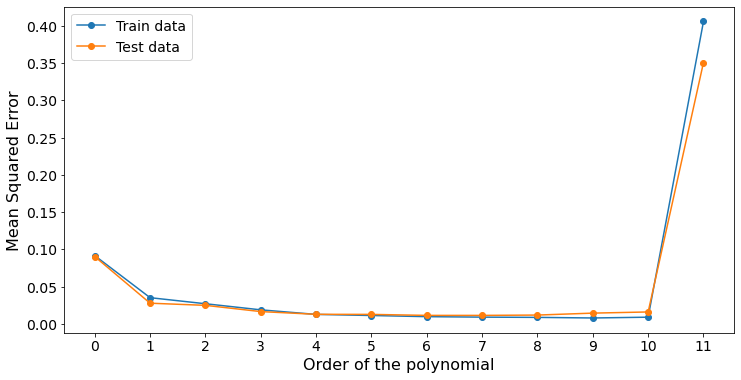

In [24]:
fig = plt.figure(figsize=(12, 6))

plt.plot(range(12),error_train, "-o", label = "Train data")
plt.plot(range(12),error_test, "-o", label = "Test data")
plt.xticks(range(12),range(12),size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.xlabel("Order of the polynomial",fontsize=16)
plt.ylabel("Mean Squared Error",fontsize=16)
plt.show()

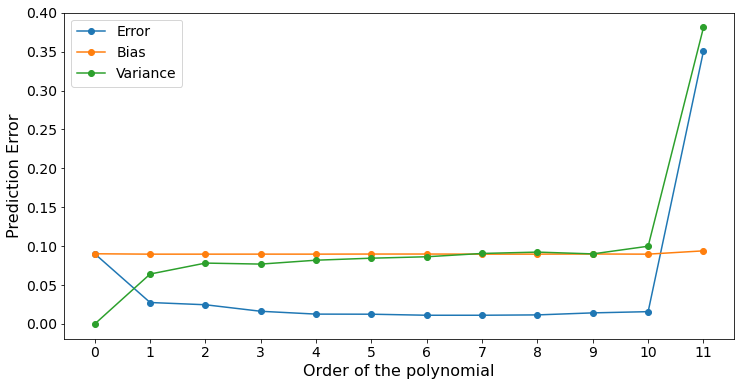

In [25]:
fig = plt.figure(figsize=(12, 6))

plt.plot(range(12),error_test, "-o", label = "Error")
plt.plot(range(12),bias, "-o", label = "Bias")
plt.plot(range(12),var, "-o", label = "Variance")
plt.xticks(range(12),range(12),size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.xlabel("Order of the polynomial",fontsize=16)
plt.ylabel("Prediction Error",fontsize=16)
plt.show()

#### Boostrap method

In [26]:
maxdegree = 11

error_test, error_train = [], []
bias = []
var = [] 

boostrap = 100

for degree in range(maxdegree+1):
    #Algorithm for splitting the data between test (10%) and train (80%)

    for no_boostrap in range(boostrap):
        #1st. Generate the position for the values we pop from the array to create the test values
        #random.seed(31415) we don't use the seed no more because we are going to resample
        test_frac=1/5
        train_pos=list(range(len(z_val)))
        test_pos=random.sample(train_pos, int(len(train_pos)*test_frac) )

        for i in test_pos:
            train_pos.remove(i)
          
        #Sort of the values for the indexes
        test_pos=np.sort(np.array(test_pos))
        train_pos=np.sort(np.array(train_pos))
        
        #2nd. Split between the train:
        xy_train, xy_test = [], []

        for i in test_pos:
            xy_test.append(xy_val[i,:])

        #and test data:
        for i in train_pos:
            xy_train.append(xy_val[i,:])

        xy_test, xy_train = np.array(xy_test), np.array(xy_train)

        x_train, y_train = xy_train[:,0], xy_train[:,1]
        X_train = DesignMatrix(x_train, y_train ,degree)

        x_test, y_test = xy_test[:,0], xy_test[:,1]
        X_test = DesignMatrix(x_test, y_test, degree)
        
        #The first iteration get the real values from Franke functions
        if no_boostrap==0: 
            z_test = FrankeFunctionNoise(xy_test[:,0], xy_test[:,1],1) 
            z_train = FrankeFunctionNoise(xy_train[:,0],xy_train[:,1],1)
            
            beta_train = estimators(X_train, z_train)
            z_model_test = X_test @ beta_train
            z_model_train = X_train @ beta_train
            
        #The rest of the iterations take the results from the previous iteration 
        else: 
            z_test = X_test @ beta_train
            z_train = X_train @ beta_train

    #We get the MSE for both test and train data:
    error_test.append(np.mean( (z_test-z_model_test)**2 ))
    error_train.append(np.mean( (z_train-z_model_train)**2 ))

    bias.append(np.mean((z_test - np.mean(z_model_test))**2) )
    var.append(np.var(z_model_test))

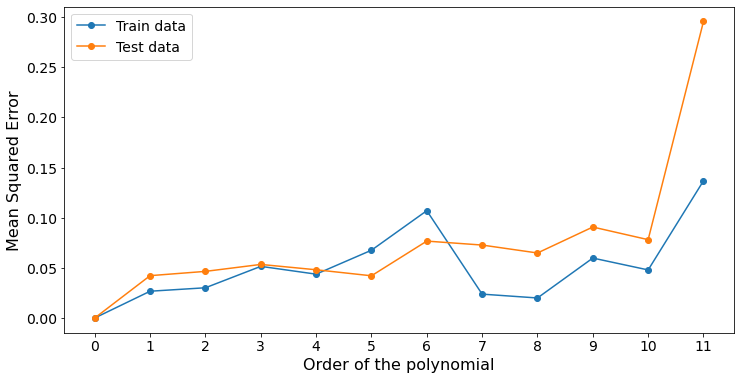

In [27]:
fig = plt.figure(figsize=(12, 6))

plt.plot(range(12),error_train, "-o", label = "Train data")
plt.plot(range(12),error_test, "-o", label = "Test data")
plt.xticks(range(12),range(12),size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.xlabel("Order of the polynomial",fontsize=16)
plt.ylabel("Mean Squared Error",fontsize=16)
plt.show()

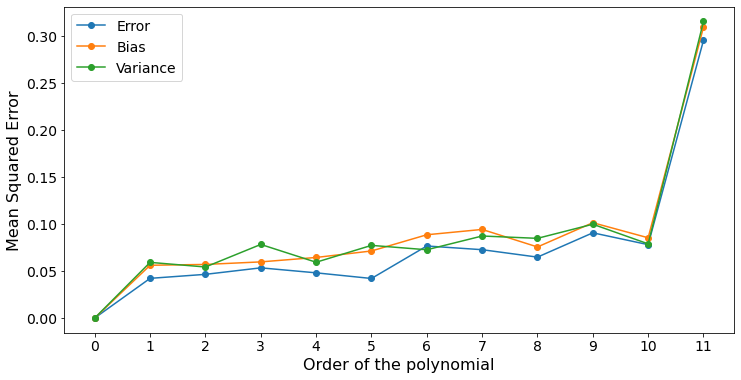

In [28]:
fig = plt.figure(figsize=(12, 6))

plt.plot(range(12),error_test, "-o", label = "Error")
plt.plot(range(12),bias, "-o", label = "Bias")
plt.plot(range(12),var, "-o", label = "Variance")
plt.xticks(range(12),range(12),size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.xlabel("Order of the polynomial",fontsize=16)
plt.ylabel("Mean Squared Error",fontsize=16)
plt.show()